# **Porównanie MFCC w CMSIS-DSP i TensorFlow**

In [ ]:
!pip install cmsisdsp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 3.6 MB/s eta 0:00:00


In [ ]:
# https://librosa.org/doc/main/generated/librosa.feature.mfcc.html
# https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms

import tensorflow as tf
import cmsisdsp as dsp
import numpy as np
import librosa
import scipy.signal as sig
from scipy.signal import windows
import cmsisdsp.mfcc as mfcc
from cmsisdsp.datatype import F32
import math
import matplotlib.pyplot as plt

# a sine signal for experiment purpouse
num_samples, sample_rate = 16000, 16000.0
frame_length = 512
frame_step=256
numOfDctOutputs = 13
freq_min = 80.0
freq_high = 7600.0
numOfMelFilters = 40

# generate a sine signal
t = np.linspace(0,1,num_samples)
pcm = np.array(np.sin(2*math.pi * t * 10),dtype=np.float32)

In [ ]:
from tensorflow.signal import linear_to_mel_weight_matrix
# MFCCs in Tensorflow
stfts = tf.signal.stft(pcm, frame_length, frame_step,
                       frame_length,
                       tf.signal.hamming_window)

spectrograms = tf.abs(stfts)

mel_matrix = linear_to_mel_weight_matrix(numOfMelFilters,
                                                                    stfts.shape[-1],
                                                                    sample_rate,
                                                                    freq_min,
                                                                    freq_high,
                                                                    tf.float32)

mel_spectrograms = tf.tensordot(spectrograms, mel_matrix, 1)
mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(mel_matrix.shape[-1:]))
log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
mfcc_tf = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :numOfDctOutputs]

mfcc_tf = tf.expand_dims(mfcc_tf, axis=-1)

print(mfcc_tf[0])

tf.Tensor(
[[-4.8378949e+00]
 [ 1.6822101e+00]
 [ 1.1185817e+00]
 [ 3.4372607e-01]
 [ 3.6551157e-01]
 [ 1.1547794e-01]
 [ 1.5012048e-01]
 [ 3.5512798e-02]
 [ 6.4227872e-02]
 [ 4.8328880e-03]
 [ 2.8744020e-02]
 [-9.2274621e-03]
 [ 9.8416712e-03]], shape=(13, 1), dtype=float32)


In [ ]:
import cmsisdsp as dsp
import numpy as np
from scipy.signal import windows
import cmsisdsp.mfcc as mfcc
from cmsisdsp.datatype import F32
import math
# MFCCs in CMSIS-DSP python wrapper

# Precomputed filters and values
window = windows.hamming(frame_length, sym=False)
filtLen,filtPos,packedFilters = mfcc.melFilterMatrix(F32, freq_min, freq_high, numOfMelFilters, sample_rate, frame_length)
dctMatrixFilters = mfcc.dctMatrix(F32,numOfDctOutputs, numOfMelFilters)

tmp=np.zeros(frame_length + 2)
mfcc_dsp = []
window_num = np.floor((num_samples - frame_length)/frame_step).astype(int) + 1

# Create and initialize MFCC instance
mfccf32=dsp.arm_mfcc_instance_f32()

status=dsp.arm_mfcc_init_f32(mfccf32,
                             frame_length,
                             numOfMelFilters,
                             numOfDctOutputs,
                             dctMatrixFilters,
                             filtPos,filtLen,
                             packedFilters,
                             window)




# in for loop calculate MFCCs for every window frame
for i in range(window_num):
    new = dsp.arm_mfcc_f32(mfccf32,pcm[frame_step * i : frame_step * i + frame_length],tmp)
    mfcc_dsp = mfcc_dsp + new.tolist()


# Convert mfcc_dsp array to numpy
mfcc_dsp = np.array(mfcc_dsp)
mfcc_dsp = mfcc_dsp.reshape((window_num,numOfDctOutputs, 1))

print(mfcc_dsp.shape)
print(mfcc_dsp[0])

(61, 13, 1)
[[-4.83790398e+00]
 [ 1.68221533e+00]
 [ 1.11857939e+00]
 [ 3.43723118e-01]
 [ 3.65514517e-01]
 [ 1.15475364e-01]
 [ 1.50126278e-01]
 [ 3.55131403e-02]
 [ 6.42303079e-02]
 [ 4.82809544e-03]
 [ 2.87466496e-02]
 [-9.23082232e-03]
 [ 9.84942913e-03]]


In [ ]:
# Print results as C++ arrays
print("/* Audio signal */");
print("const float32_t audio[] = {", ", ".join(map(str, pcm)), "}; ")
print("/* Internal DCT coefficients */");
print("const float32_t dctCoefs[] = {", ", ".join(map(str, dctMatrixFilters)), "}; ")
print("/* Internal Mel filter coefficients */")
print("const float32_t filterCoefs[] = {", ", ".join(map(str, packedFilters)), "}; ")
print("/* Windowing coefficients */ ")
print("const float32_t windowCoefs[] = {", ", ".join(map(str, window)), "}; ")
print("/* Internal Mel filter positions in spectrum */ ")
print("const uint32_t filterPos[] = {", ", ".join(map(str, filtPos)), "};")
print("/* Internal Mel filter  lengths */ ")
print("const uint32_t filterLengths[] = {", ", ".join(map(str, filtLen)), "}; ")

print("const uint32_t fftLen = " + str(frame_length) + "; /* FFT length */")
print("const uint32_t fftStep = " + str(frame_step) + "; /* FFT Step */")
print("const uint32_t nbMelFilters = " + str(numOfMelFilters) + "; /* Number of Mel filters */")
print("const uint32_t nbDctOutputs = " + str(numOfDctOutputs) + "; /* Number of DCT outputs */")
print("const uint32_t window_num = " + str(window_num) + "; /* Number of windows */")

/* Audio signal */
const float32_t audio[] = { 0.0, 0.003927226, 0.007854392, 0.011781436, 0.0157083, 0.01963492, 0.023561237, 0.027487192, 0.03141272, 0.03533777, 0.03926227, 0.043186165, 0.04710939, 0.051031895, 0.054953612, 0.05887448, 0.06279444, 0.06671343, 0.07063139, 0.07454827, 0.07846399, 0.0823785, 0.086291745, 0.09020366, 0.09411418, 0.09802325, 0.101930805, 0.10583679, 0.109741144, 0.1136438, 0.11754471, 0.12144381, 0.12534103, 0.12923631, 0.13312961, 0.13702086, 0.14090998, 0.14479694, 0.14868166, 0.1525641, 0.15644416, 0.16032183, 0.16419701, 0.16806968, 0.17193975, 0.17580715, 0.17967185, 0.18353379, 0.18739289, 0.1912491, 0.19510236, 0.19895262, 0.2027998, 0.20664385, 0.21048471, 0.21432234, 0.21815665, 0.2219876, 0.22581513, 0.22963919, 0.23345968, 0.23727658, 0.24108984, 0.24489935, 0.2487051, 0.252507, 0.25630504, 0.26009908, 0.26388916, 0.26767513, 0.271457, 0.27523464, 0.2790081, 0.2827772, 0.28654197, 0.2903023, 0.29405814, 0.29780948, 0.3015562, 0.3052983, 0.3090

In [ ]:
# MFCC in Librosa
mfcc_L = librosa.feature.mfcc(y=np.array(pcm),
        sr=sample_rate,
        n_mfcc=numOfDctOutputs,
        n_fft = frame_length,
        hop_length = frame_step,
        window=windows.hann(frame_length, sym=False),
        center=False,            # for padding, not used
        pad_mode='symmetric',    # for padding, not used
        power=1.0,
        n_mels=numOfMelFilters,
        fmin=freq_min,
        fmax=freq_high,
        dct_type=2,
        norm='ortho',
        htk=True
        )

mfcc_L = mfcc_L.reshape((window_num+1,numOfDctOutputs, 1))

print(mfcc_L)
print(mfcc_L.shape)

Exception ignored in: <function _xla_gc_callback at 0x7ed28d1f6170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


ValueError: cannot reshape array of size 793 into shape (62,13,1)

In [ ]:
print("mfccs shape in TensorFlow")
print(mfcc_tf.shape)
print("mfccs shape in CMSIS-DSP")
print(mfcc_dsp.shape)
print("mfccs shape in Librosa")
print(mfcc_L.shape)

mfccs shape in TensorFlow
(1, 13, 1)
mfccs shape in CMSIS-DSP
(1, 13, 1)
mfccs shape in Librosa
(1, 13, 1)


In [ ]:
i = 0
print("compared frame number: " + str(i))
print(mfcc_tf[i])
print("")
print(mfcc_dsp[i])
print("")
print(mfcc_L[i])

compared frame number: 0
tf.Tensor(
[[-20.596483  ]
 [  2.464584  ]
 [ -0.7020946 ]
 [ -3.7404745 ]
 [ -4.817388  ]
 [ -4.5897183 ]
 [ -2.6599133 ]
 [ -0.16193205]
 [  2.2061698 ]
 [  3.3353684 ]
 [  3.019446  ]
 [  1.3967772 ]
 [ -0.61863047]], shape=(13, 1), dtype=float32)

[[-20.59649658]
 [  2.46455193]
 [ -0.70209205]
 [ -3.74051762]
 [ -4.81739902]
 [ -4.58973598]
 [ -2.65996361]
 [ -0.16193604]
 [  2.20614052]
 [  3.33534002]
 [  3.01940751]
 [  1.39678383]
 [ -0.61865777]]

[[-306.4283    ]
 [ 106.93319   ]
 [  -2.3411913 ]
 [ -18.582077  ]
 [ -36.091774  ]
 [ -25.908787  ]
 [ -16.689018  ]
 [   0.87871456]
 [   9.188057  ]
 [  15.021379  ]
 [  10.640631  ]
 [   5.131878  ]
 [  -3.4097848 ]]


# **Fetch data from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r /content/content
!mkdir content

rm: cannot remove '/content/content': No such file or directory


In [ ]:
!unzip /content/drive/MyDrive/ASR/key_words_with_noise2.zip -d /content/content

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: /content/content/key_words_with_noise/8/3448.wav  
  inflating: /content/content/key_words_with_noise/8/3449.wav  
  inflating: /content/content/key_words_with_noise/8/345.wav  
  inflating: /content/content/key_words_with_noise/8/3450.wav  
  inflating: /content/content/key_words_with_noise/8/3451.wav  
  inflating: /content/content/key_words_with_noise/8/3452.wav  
  inflating: /content/content/key_words_with_noise/8/3453.wav  
  inflating: /content/content/key_words_with_noise/8/3454.wav  
  inflating: /content/content/key_words_with_noise/8/3455.wav  
  inflating: /content/content/key_words_with_noise/8/3456.wav  
  inflating: /content/content/key_words_with_noise/8/3457.wav  
  inflating: /content/content/key_words_with_noise/8/3458.wav  
  inflating: /content/content/key_words_with_noise/8/3459.wav  
  inflating: /content/content/key_words_with_noise/8/346.wav  
  inflating: /content/content/key_words_w

# **Import Tensorflow**

In [ ]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.saving import load_model
import tensorflow_model_optimization as tfmot
print(tfmot.__version__)

seed = 42
tf.random.set_seed(seed)

0.8.0


# **Load Datasets**

In [ ]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
import librosa
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

np.random.seed(42)

In [ ]:
data_dir = Path("/content/content/key_words_with_noise")

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    labels = "inferred",
    batch_size=64,
    validation_split=0.2,
    seed=42,
    output_sequence_length=16000,
    subset='both')


Found 39429 files belonging to 11 classes.
Using 31544 files for training.
Using 7885 files for validation.


In [ ]:
sample_rate = 16000
num_samples = 16000
frame_length = 512
frame_step = 256
numOfDctOutputs = 13
freq_min = 80.0
freq_high = 7600.0
numOfMelFilters = 40
windows_num = np.floor((num_samples - frame_length)/frame_step).astype(int) + 1

def compute_mfcc(audio, label):
    # input audio shape = (16000, 1)

    audio = tf.squeeze(audio, axis=-1)

    stfts = tf.signal.stft(audio, frame_length, frame_step, frame_length, tf.signal.hamming_window)

    spectrograms = tf.abs(stfts)

    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(numOfMelFilters,
                                                                    stfts.shape[-1],
                                                                    sample_rate,
                                                                    freq_min,
                                                                    freq_high,
                                                                    tf.float32)

    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    mfcc = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :numOfDctOutputs]

    batch_size = tf.shape(mfcc)[0]
    mfcc = tf.reshape(mfcc, [batch_size, -1])

    return mfcc, label

train_ds = train_ds.map(compute_mfcc, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(compute_mfcc, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_audio[0])

(64, 793)
tf.Tensor(
[ 1.27885408e+01  1.23498440e+00 -7.31239676e-01  1.38558948e+00
  6.80791914e-01 -4.08291191e-01 -9.05849263e-02  1.04759812e-01
  1.11048460e+00  3.44034851e-01  5.57163060e-02 -2.27742285e-01
  1.35244191e-01  1.23022175e+01  1.09452188e+00 -5.24485856e-02
  1.33934712e+00  9.53810394e-01 -2.00719342e-01 -5.20616293e-01
 -4.29534823e-01  1.09909391e+00 -2.76255846e-01  1.64692298e-01
 -3.75058383e-01 -2.86840975e-01  1.21893873e+01  1.46996319e+00
  6.90680385e-01  1.14470267e+00  9.37061787e-01 -1.62927568e-01
 -9.24413800e-01  5.93888983e-02  1.00878417e+00 -2.47788966e-01
 -2.99607933e-01 -3.18328649e-01 -4.84188020e-01  1.24951811e+01
  1.69662476e+00  2.43221939e-01  1.04646766e+00  9.82404888e-01
  2.04993650e-01 -3.01182061e-01  2.47368604e-01  1.06597698e+00
  5.90599552e-02  3.55427682e-01 -1.25050232e-01  3.70828897e-01
  1.22271433e+01  1.12433279e+00  1.80732533e-01  1.09467793e+00
  6.84259653e-01  3.91450673e-02  5.07382035e-01  7.84445584e-01
  1.

In [ ]:
# Get the input shape of the MFCCs
# Assuming train_ds contains a dataset of (mfccs, labels), extract a single example
for mfccs, labels in train_ds.take(1):
    input_shape = mfccs.shape[1:]  # Exclude the batch dimension
    num_classes = labels.shape[-1] if labels.ndim > 1 else tf.reduce_max(labels).numpy() + 1

print("Input shape:", input_shape)
print("Number of classes:", num_classes)

Input shape: (793,)
Number of classes: 11


In [ ]:
# Define the CNN model
model = Sequential([
    Input(shape=input_shape),
    Reshape((windows_num, numOfDctOutputs, 1)),
    Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.build()
# Print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 61, 13, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 59, 11, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 29, 5, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 3, 32)           │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          53,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,451 (318.17 KB)

 Trainable params: 81,451 (318.17 KB)

 Non-trainable params: 0 (0.00 B)

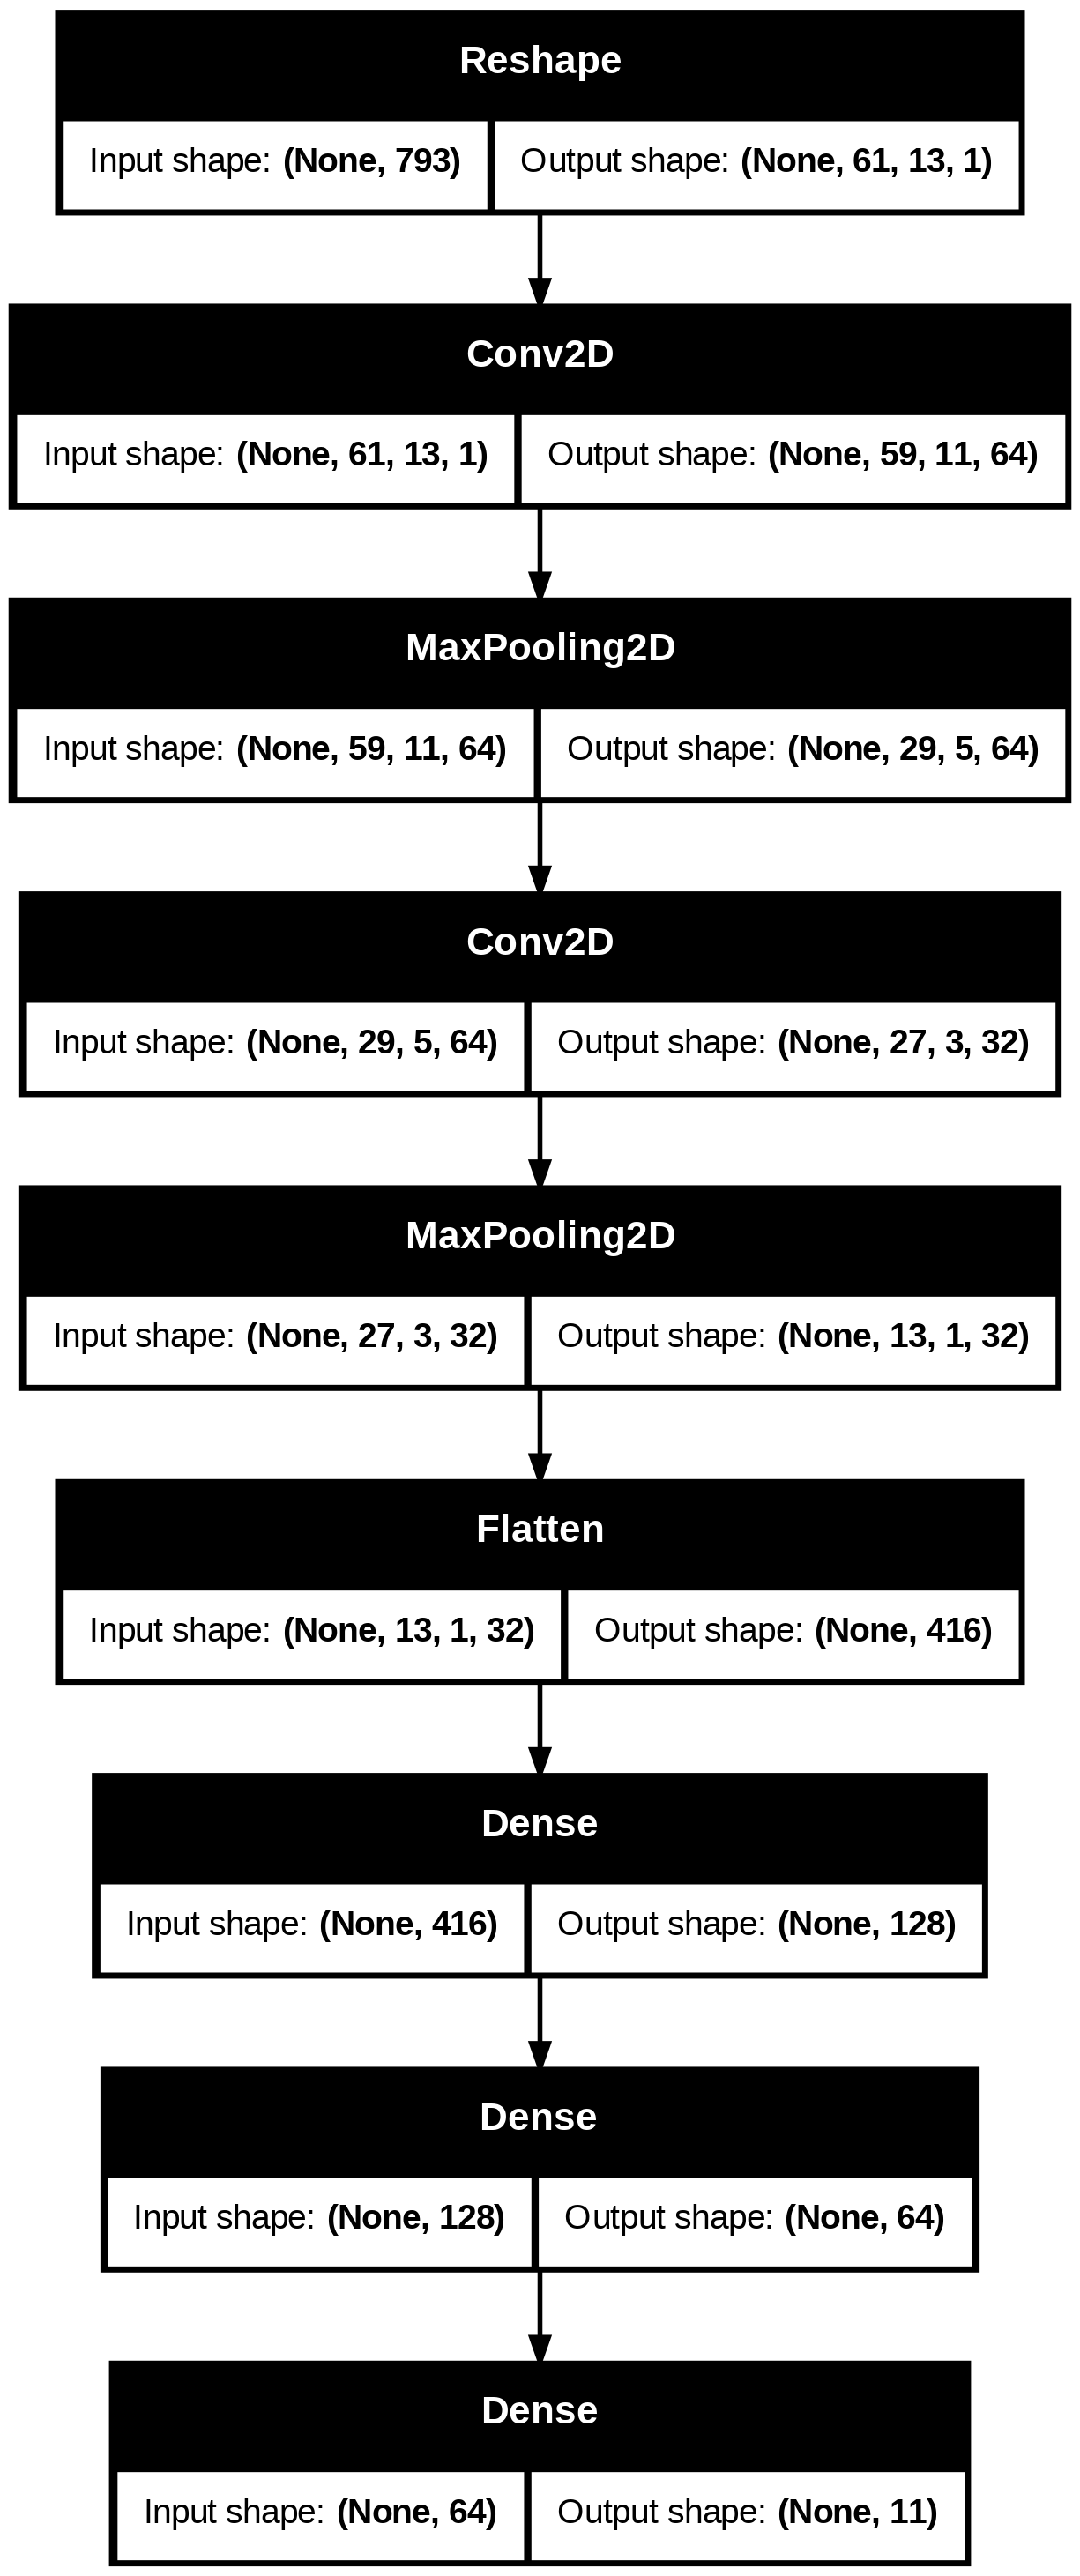

In [ ]:
# Plot the model architecture
plot_model(model, "ticket_classifier.png", show_shapes=True)

In [ ]:
callbacks_list = [
    ModelCheckpoint(filepath="/content/drive/MyDrive/ASR/models/20_01/model.keras", monitor="val_loss", save_best_only=True)]

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks_list)

Epoch 1/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 63s 122ms/step - accuracy: 0.2570 - loss: 2.0311 - val_accuracy: 0.5403 - val_loss: 1.2766
Epoch 2/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 84s 126ms/step - accuracy: 0.6093 - loss: 1.1088 - val_accuracy: 0.6813 - val_loss: 0.9126
Epoch 3/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - accuracy: 0.7118 - loss: 0.8236 - val_accuracy: 0.7408 - val_loss: 0.7512
Epoch 4/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.7618 - loss: 0.6801 - val_accuracy: 0.7654 - val_loss: 0.6804
Epoch 5/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - accuracy: 0.7920 - loss: 0.5941 - val_accuracy: 0.7647 - val_loss: 0.6786
Epoch 6/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 58s 117ms/step - accuracy: 0.8154 - loss: 0.5320 - val_accuracy: 0.7787 - val_loss: 0.6511
Epoch 7/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 80s 112ms/step - accuracy: 0.8297 - loss: 0.4916 - val_accuracy: 0.7806 - val_loss: 0.6537
Epoch 8/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 56s 113ms/step - accuracy: 0.8414 - loss: 0

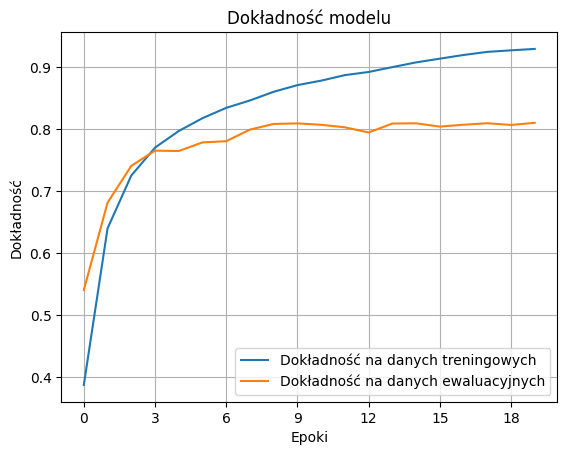

In [ ]:
from matplotlib.ticker import MaxNLocator
plt.figure()
plt.plot(history.history['accuracy'], label='Dokładność na danych treningowych')
plt.plot(history.history['val_accuracy'], label='Dokładność na danych ewaluacyjnych')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.title('Dokładność modelu')
plt.legend()
plt.savefig("accuracy.svg")
plt.show()

In [ ]:
# Get the true labels and predictions
true_labels = []
predicted_labels = []

for mfccs, labels in val_ds:
    # Predict using the trained model
    predictions = model.predict(mfccs, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability
    true_labels.extend(labels.numpy())  # Add true labels
    predicted_labels.extend(predicted_classes)  # Add predicted labels

# Convert to numpy arrays for easier processing
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

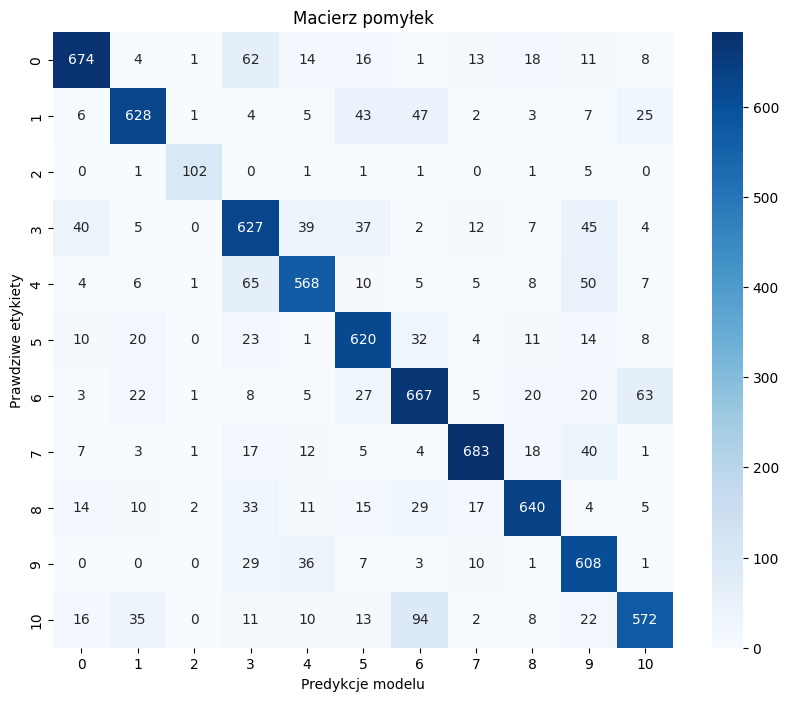

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(11), yticklabels=range(11))
plt.title('Macierz pomyłek')
plt.xlabel('Predykcje modelu')
plt.ylabel('Prawdziwe etykiety')
plt.savefig("confusion_matrix.svg")
plt.show()

# **Post training dynamic range quantization**

In [ ]:
model_path = "/content/drive/MyDrive/ASR/models/20_01/model.keras"

model = load_model(model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
lite_model = converter.convert()

Saved artifact at '/tmp/tmph8_3bmwl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 793), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  139979979290384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979987156432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979987151440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979987148368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979987156816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979986159376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979987156240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979986158800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979986158416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979986160336: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
len(lite_model)

93672

### Save quantized model to file

In [ ]:
lite_model_file = Path("/content/drive/MyDrive/ASR/models/20_01/model.tflite")
lite_model_file.write_bytes(lite_model)

93672

In [ ]:
lite_model_file.write_bytes(lite_model)

93672

In [ ]:
!ls -lh {lite_model_file}

-rw------- 1 root root 92K Jan 20 20:23 /content/drive/MyDrive/ASR/models/05_01/model_1.tflite


# **Test quantized model**

In [ ]:
mfcc = None
label = None
num = 10

for mfccs, labels in val_ds.take(1):
    mfcc = mfccs[num]
    label = labels[num]

mfcc = mfcc.numpy()
label = label.numpy()

mfcc = np.expand_dims(mfcc, axis=0).astype(np.float32)

print(type(mfcc))
print(mfcc.shape)
print(label)

<class 'numpy.ndarray'>
(1, 793)
3


In [ ]:

lite_model_file = Path("/content/drive/MyDrive/ASR/models/05_01/model_1.tflite")

interpreter = tf.lite.Interpreter(model_path=str(lite_model_file))
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, mfcc)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

print(predictions)

np.argmax(predictions[0])

[[8.6392060e-02 1.2498073e-08 3.7788119e-12 9.1238576e-01 8.1654050e-04
  1.3891398e-05 5.7521842e-08 5.5237171e-05 3.0211487e-04 3.4031800e-05
  2.2629975e-07]]


3

In [ ]:
def evaluate_model(interpreter, batch_num):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    mfccs = None
    labels = None
    predictions = np.array([])
    for d, l in val_ds.take(batch_num):
        mfccs = d
        labels = l

    mfccs = mfccs.numpy()
    labels = labels.numpy()

    print(labels[0:10])

    for mfcc in mfccs:
        mfcc = np.expand_dims(mfcc, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, mfcc)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        predictions = np.append(predictions, digit)

    print(predictions.astype(int)[0:10])
    print(len(predictions))

    accurate_count = 0
    for index in range(len(predictions)):
        if predictions[index] == labels[index]:
            accurate_count += 1

    accuracy = accurate_count * 1.0 / len(predictions)
    return accuracy

In [ ]:
acc = evaluate_model(interpreter, 5)
print("Accuracy: ", str(acc))

[ 7  0 10  5  5  9  1  4  5  3]
[7 0 6 5 5 9 1 4 5 8]
64
Accuracy:  0.765625


### Convert quantized model to C array

In [ ]:
!xxd -i /content/drive/MyDrive/ASR/models/20_01/model.tflite > /content/drive/MyDrive/ASR/models/20_01/model.cc

# **Post training quanitization, full integer model with float input and output**

In [ ]:
def representative_data_gen():
    for example_audio, example_labels in train_ds.take(1):
        # Model has only one input so each data point has one element.
        yield[example_audio]


In [ ]:
model_path = "/content/drive/MyDrive/ASR/models/20_01/model.keras"
model = load_model(model_path)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_full_int = converter.convert()

Saved artifact at '/tmp/tmp67lqvusa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 793), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  139979982473168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979982473552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979982473744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979982474704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979987154128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979987153360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979982472208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979982475472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979982474896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139979982476432: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_full_int)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [ ]:
tflite_model_full_int_file = Path("/content/drive/MyDrive/ASR/models/20_01/model_full_int.tflite")
tflite_model_full_int_file.write_bytes(tflite_model_full_int)

95248

In [ ]:
!xxd -i /content/drive/MyDrive/ASR/models/20_01/model_full_int.tflite > /content/drive/MyDrive/ASR/models/20_01/model_full_int.cpp

# Testing mfccs and models on the RPi Pico

In [ ]:
key_0_wav = "/content/content/key_words_with_noise/0/0.wav"
key_1_wav = "/content/content/key_words_with_noise/1/0.wav"
key_2_wav = "/content/content/key_words_with_noise/2/0.wav"

In [ ]:
pip install tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 22.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor(key_1_wav)
audio = audio.to_tensor()
audio = tf.cast(audio, tf.float32) / 32768.0
print(audio)

NameError: name 'key_1_wav' is not defined

In [ ]:
audio_np = audio.numpy()
audio_np = np.reshape(audio_np, (-1))
print(audio_np)

In [ ]:
print("/* audio signal */");
print("const float32_t audio[] = {", ", ".join(map(str, audio_np)), "}; ")
print("")

/* audio signal */


NameError: name 'audio_np' is not defined